# Setup dependence

In [9]:
import cv2
import numpy as np 
import os 
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Keypoints using Media Pipe Holistic

In [10]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [11]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image) # Make prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [12]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, \
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), \
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1) \
                             )
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, \
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), \
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2) \
                             ) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, \
                             mp_drawing.DrawingSpec(color=(80,22,76), thickness=2, circle_radius=4), \
                             mp_drawing.DrawingSpec(color=(80,44,250), thickness=2, circle_radius=2) \
                             ) 
    
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, \
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), \
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) \
                             ) 

In [13]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():
#         # Read feed
#         ret, frame = cap.read()

#         # Make detection
#         image, results = mediapipe_detection(frame, holistic)
        
#         # Draw landmarks
#         draw_landmarks(image, results)

#         # Show on screen
#         cv2.imshow('OpenCV stream', image)

#         # Break
#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             break

# cap.release()
# cv2.destroyAllWindows()

# Extract keypoint values

In [14]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() \
            if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
            if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
            if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
            if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [15]:
# extract_keypoints(results)

# Setup folders for collection

In [16]:
# Path for exported data
DATA_PATH = os.path.join('MP_data')

# Action to detect
actions = np.array(['Hello', 'Thanks', 'I Love You'])

# 30 videos work of data
no_sequences = 30

# Videos have 30 frame in length
sequence_length = 30

In [17]:
# Create 30 folders for each action
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action.replace(' ', '_'), str(sequence)))
        except: 
            pass

# Collect keypoint values for training and testing

In [18]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # Loop through actions and sequences
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()

                # Make detection
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, f'STARTING COLLECTION FOR {action.upper()} AFTER 2S', (120,200), \
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, f'Collecting frames for {action}, Video number: {sequence}', (15,12), \
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    
                    # Show on screen
                    cv2.imshow('OpenCV stream', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, f'Collecting frames for {action}, Video number: {sequence}', (15,12), \
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV stream', image)
                
                # Save keypoints
                keypoints = extract_keypoints(results)
                npy_save_path = os.path.join(DATA_PATH, action.replace(' ', '_'), str(sequence), str(frame_num))
                np.save(npy_save_path, keypoints)


                # Break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()

In [19]:
cap.release()
cv2.destroyAllWindows()

# Preprocess data, create labels and features

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [99]:
label_map = {label:num for num, label in enumerate(actions)}

In [100]:
label_map

{'Hello': 0, 'Thanks': 1, 'I Love You': 2}

In [103]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action.replace(' ', '_'), str(sequence), f'{frame_num}.npy'))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [104]:
np.array(sequences).shape

(90, 30, 1662)

In [105]:
np.array(labels).shape

(90,)

In [106]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [107]:
print(X.shape, y.shape)

(90, 30, 1662) (90, 3)


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [109]:
X_train.shape

(85, 30, 1662)

In [110]:
y_train.shape

(85, 3)

# Build and train LSTM model

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [112]:
log_dir = os.path.join('log')
tb_callback = TensorBoard(log_dir=log_dir)

In [145]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [122]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_25 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_26 (LSTM)              (None, 64)                49408     
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

In [123]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [124]:
model.fit(X_train, y_train, epochs=30, callbacks=[tb_callback])

Epoch 1/30
3/3 [==============================] - 4s 202ms/step - loss: 2.2492 - categorical_accuracy: 0.3294
Epoch 2/30
3/3 [==============================] - 1s 193ms/step - loss: 1.2810 - categorical_accuracy: 0.3176
Epoch 3/30
3/3 [==============================] - 1s 252ms/step - loss: 1.5338 - categorical_accuracy: 0.2941
Epoch 4/30
3/3 [==============================] - 1s 197ms/step - loss: 1.1474 - categorical_accuracy: 0.2471
Epoch 5/30
3/3 [==============================] - 1s 195ms/step - loss: 1.0088 - categorical_accuracy: 0.5412
Epoch 6/30
3/3 [==============================] - 1s 223ms/step - loss: 1.2827 - categorical_accuracy: 0.2824
Epoch 7/30
3/3 [==============================] - 1s 209ms/step - loss: 1.2205 - categorical_accuracy: 0.4000
Epoch 8/30
3/3 [==============================] - 1s 224ms/step - loss: 1.1299 - categorical_accuracy: 0.3412
Epoch 9/30
3/3 [==============================] - 1s 218ms/step - loss: 1.0546 - categorical_accuracy: 0.3176
Epoch 10/3

# Prediction

In [125]:
res = model.predict(X_test)

1/1 [==============================] - 0s 364ms/step


In [141]:
actions[np.argmax(res[4])]

'Hello'

In [139]:
actions[np.argmax(y_test[4])]

'Hello'

# Save weights

In [142]:
model.save('action.h5')

In [143]:
del model

In [146]:
model.load_weights('action.h5')

# Evaluation

In [147]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [148]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 397ms/step


In [149]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [150]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [0, 3]],

       [[4, 0],
        [0, 1]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [151]:
accuracy_score(ytrue, yhat)

1.0

# Test in real time

In [152]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

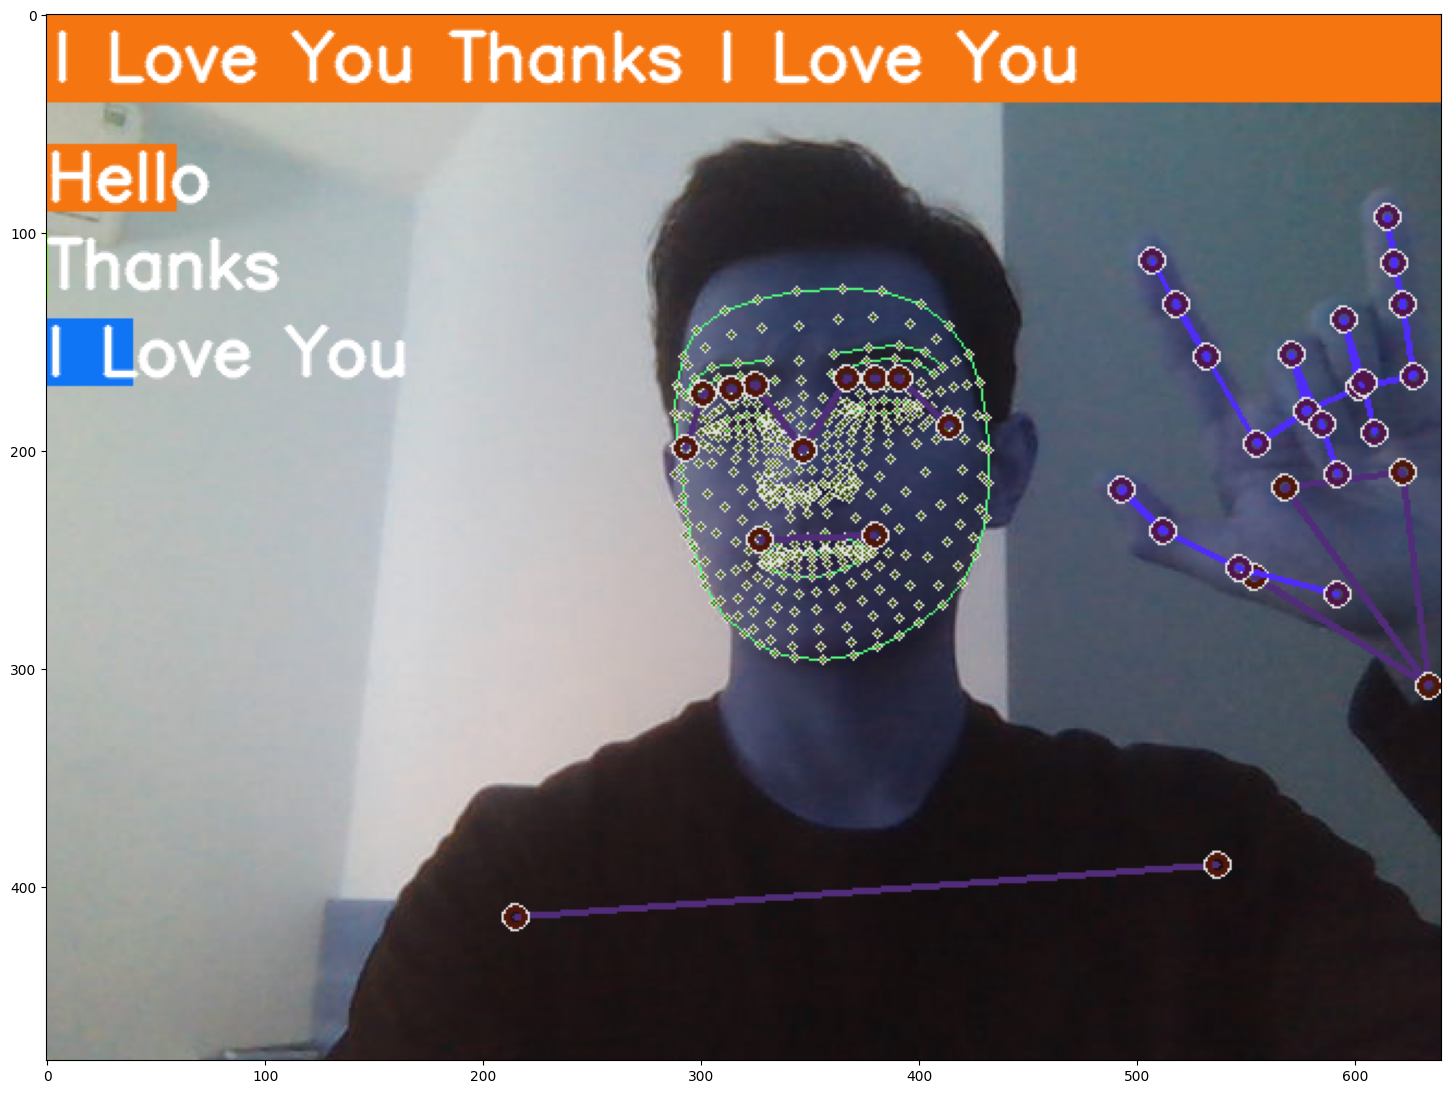

In [159]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [160]:
cap.release()
cv2.destroyAllWindows()